## Imports

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import calendar
import matplotlib.pyplot as plt


## Utils

In [22]:
def get_days_in_month(year, month):
    _, num_days = calendar.monthrange(year, month)
    return num_days

def get_day_in_year(year, month, day):
    day_in_year = 0

    for m in range(1, month):
        day_in_year += get_days_in_month(year, m)

    day_in_year += day - 1

    return day_in_year

## Tractament de dades

In [23]:
observations = pd.read_csv("../Data/gene_sconcno2_2023_xvpca_emep_port.csv")
stations_info = pd.read_csv("../Data/XVPCA_info_sconcno2_2023.csv")

In [24]:
unique_stations = observations.columns[1:]  # Excluim la columna "Date"
stations_train, stations_test = train_test_split(unique_stations, test_size=0.2, random_state=42)

observations_training = observations[["Date"] + stations_train.tolist()]
observations_testing = observations[["Date"] + stations_test.tolist()]

observations_training = observations_training.melt(id_vars=["Date"], var_name="Station", value_name="concentration")
observations_testing = observations_testing.melt(id_vars=["Date"], var_name="Station", value_name="concentration")

stations_info.rename(columns={"code": "Station", "lat": "Latitude", "lon": "Longitude"}, inplace=True)

observations_training = observations_training.merge(stations_info, on="Station", how="left")
observations_testing = observations_testing.merge(stations_info, on="Station", how="left")

observations_training = observations_training[["Date", "Latitude", "Longitude", "concentration"]]
observations_testing = observations_testing[["Date", "Latitude", "Longitude", "concentration"]]

observations_training.rename(columns={"Date": "date", "Latitude": "lat", "Longitude": "lon"}, inplace=True)
observations_testing.rename(columns={"Date": "date", "Latitude": "lat", "Longitude": "lon"}, inplace=True)

observations_training.dropna(subset=["lat", "lon", "concentration"], inplace=True)
observations_testing.dropna(subset=["lat", "lon", "concentration"], inplace=True)

In [25]:
observations_training

,date,lat,lon,concentration
0,2022-12-31 23:00:00,41.313475,2.013825,25.0
1,2023-01-01 00:00:00,41.313475,2.013825,36.0
2,2023-01-01 01:00:00,41.313475,2.013825,36.0
3,2023-01-01 02:00:00,41.313475,2.013825,35.0
4,2023-01-01 03:00:00,41.313475,2.013825,28.0
...,...,...,...,...
446755,2023-12-31 18:00:00,41.103678,1.200765,19.0
446756,2023-12-31 19:00:00,41.103678,1.200765,19.0
446757,2023-12-31 20:00:00,41.103678,1.200765,13.0
446758,2023-12-31 21:00:00,41.103678,1.200765,9.0


In [26]:
data_transformed_training = observations_training.copy()

data_transformed_training['date'] = pd.to_datetime(data_transformed_training['date'])

data_transformed_training['day_in_year'] = data_transformed_training.apply(
    lambda row: get_day_in_year(row['date'].year, row['date'].month, row['date'].day), axis=1
)
data_transformed_training['hour'] = data_transformed_training['date'].dt.hour

data_transformed_training = data_transformed_training.drop(columns=['date'])

data_transformed_testing = observations_testing.copy()

data_transformed_testing['date'] = pd.to_datetime(data_transformed_testing['date'])

data_transformed_testing['day_in_year'] = data_transformed_testing.apply(
    lambda row: get_day_in_year(row['date'].year, row['date'].month, row['date'].day), axis=1
)
data_transformed_testing['hour'] = data_transformed_testing['date'].dt.hour

data_transformed_testing = data_transformed_testing.drop(columns=['date'])

print("Exemple Data Transformed Training:")
data_transformed_training.iloc[9999]

Exemple Data Transformed Training:


lat              41.102222
lon               1.149444
concentration    15.000000
day_in_year      77.000000
hour             19.000000
Name: 10628, dtype: float64

In [27]:
X_train = data_transformed_training[["lat", "lon", "day_in_year", "hour"]]
y_train = data_transformed_training["concentration"]

X_test = data_transformed_testing[["lat", "lon", "day_in_year", "hour"]]
y_test = data_transformed_testing["concentration"]

In [28]:
X_test

,lat,lon,day_in_year,hour
37,42.36839,1.776814,1,12
38,42.36839,1.776814,1,13
39,42.36839,1.776814,1,14
40,42.36839,1.776814,1,15
41,42.36839,1.776814,1,16
...,...,...,...,...
113875,41.73028,1.825306,364,18
113876,41.73028,1.825306,364,19
113877,41.73028,1.825306,364,20
113878,41.73028,1.825306,364,21


## Models

In [29]:
model = RandomForestRegressor(random_state=42, n_estimators=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

comparison = data_transformed_testing.copy()
comparison["predicted_concentration"] = y_pred
print("\nComparison of Actual vs Predicted:")
print(comparison[["concentration", "predicted_concentration"]].head())

Root Mean Squared Error (RMSE): 11.819576100547218
R-squared (R2): 0.35052561525475856

Comparison of Actual vs Predicted:
    concentration  predicted_concentration
37           16.0                     19.0
38            9.0                     25.2
39            7.0                     31.8
40           11.0                     33.9
41           29.0                     46.6


In [30]:
def prepare_predictions_with_date(X_test, y_pred, year, minute):
    predictions_df = X_test.copy()

    predictions_df['concentration'] = y_pred

    predictions_df['date'] = pd.to_datetime(predictions_df['day_in_year'], format='%j', errors='coerce').apply(
        lambda x: x.replace(year=year) if pd.notnull(x) else x)
    
    predictions_df['date'] = predictions_df.apply(
        lambda row: row['date'].replace(hour=row['hour'], minute=minute) if pd.notnull(row['date']) else row['date'],
        axis=1)
    
    predictions_df['date'] = predictions_df['date'].dt.strftime('%Y-%m-%d %H:%M')

    predictions_df = predictions_df.sort_values(by='date', ascending=True)

    predictions_df['id'] = range(1, len(predictions_df) + 1)

    result_df = predictions_df[['id', 'date', 'lat', 'lon', 'concentration']]

    return result_df

In [31]:
year = 2023
minute = 0

result_df = prepare_predictions_with_date(X_test, y_pred, year, minute)

print(result_df.head())


       id              date        lat       lon  concentration
17545   1  2023-01-01 00:00  41.317277  2.134501           54.1
35065   2  2023-01-01 00:00  41.403716  2.204736           33.8
61345   3  2023-01-01 00:00  41.321495  2.097725           21.7
87625   4  2023-01-01 00:00  40.706709  0.581651           13.8
43825   5  2023-01-01 00:00  41.150779  1.120172            7.8


## Generem una predicció per a les 4 estacions del kaggle

In [32]:
def generate_X_test(locations, year):
    
    days_in_year = 366 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 365
    
    data = []

    for lat, lon in locations:
        for day_in_year in range(1, days_in_year + 1):
            for hour in range(0, 24):
                data.append([lat, lon, day_in_year, hour])
    
    X_test = pd.DataFrame(data, columns=["lat", "lon", "day_in_year", "hour"])

    return X_test

In [33]:
locations = [(41.39216, 2.009802), (41.11588, 1.191975), (41.44398, 2.237875), (41.32177, 2.082141), (42.3191737364928, 3.31582774471250)]

X_test_Kaggle = generate_X_test(locations, 2023)

X_test_Kaggle

,lat,lon,day_in_year,hour
0,41.392160,2.009802,1,0
1,41.392160,2.009802,1,1
2,41.392160,2.009802,1,2
3,41.392160,2.009802,1,3
4,41.392160,2.009802,1,4
...,...,...,...,...
43795,42.319174,3.315828,365,19
43796,42.319174,3.315828,365,20
43797,42.319174,3.315828,365,21
43798,42.319174,3.315828,365,22


In [34]:
year = 2023
minute = 0

model = RandomForestRegressor(random_state=42, n_estimators=50)
model.fit(X_train, y_train)

y_pred_Kaggle = model.predict(X_test_Kaggle)

resultat_kaggle = prepare_predictions_with_date(X_test_Kaggle, y_pred_Kaggle, year, minute)
resultat_kaggle

#Creem un csv amb els resultats
resultat_kaggle.to_csv('predictions_kaggle.csv', index=False)

In [35]:
resultat_kaggle

,id,date,lat,lon,concentration
0,1,2023-01-01 00:00,41.392160,2.009802,25.1600
8760,2,2023-01-01 00:00,41.115880,1.191975,18.3000
35040,3,2023-01-01 00:00,42.319174,3.315828,2.3196
17520,4,2023-01-01 00:00,41.443980,2.237875,38.3000
26280,5,2023-01-01 00:00,41.321770,2.082141,23.7200
...,...,...,...,...,...
35039,43796,2023-12-31 23:00,41.321770,2.082141,34.0400
17519,43797,2023-12-31 23:00,41.115880,1.191975,20.9400
8759,43798,2023-12-31 23:00,41.392160,2.009802,27.7200
26279,43799,2023-12-31 23:00,41.443980,2.237875,43.1200


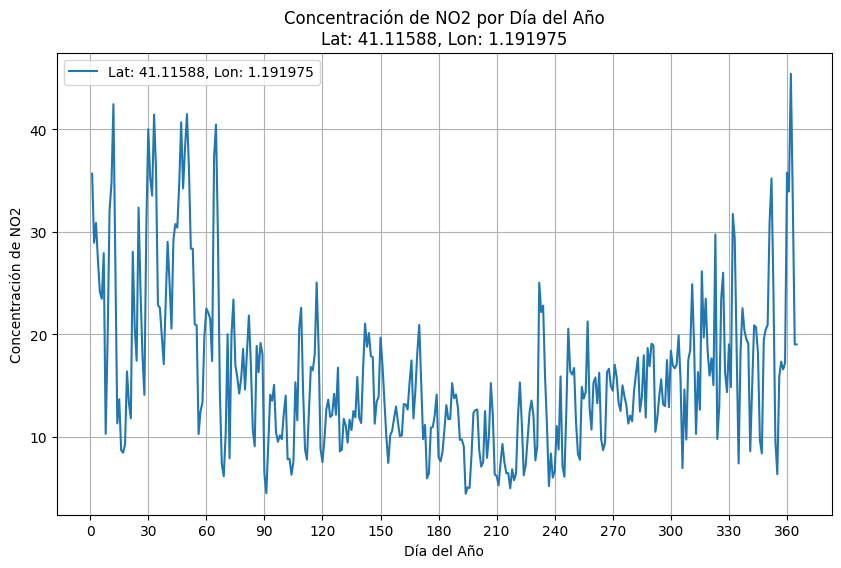

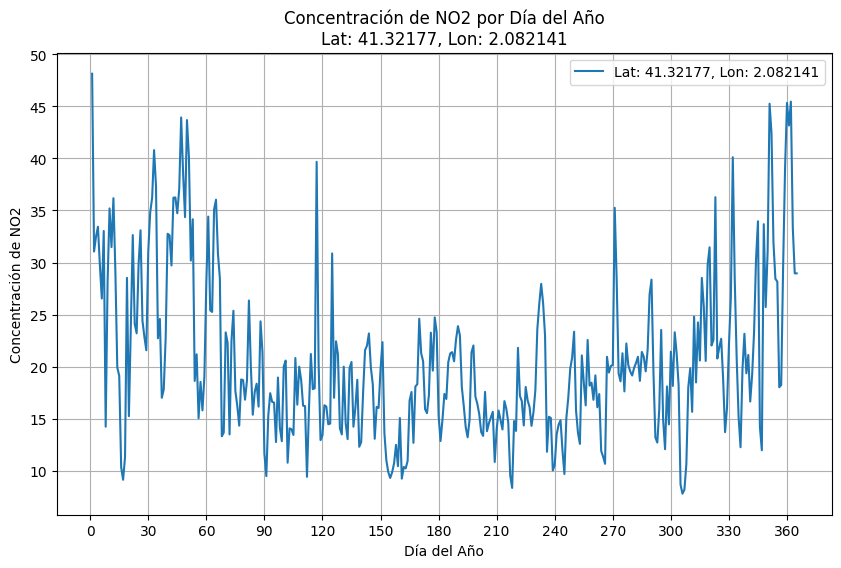

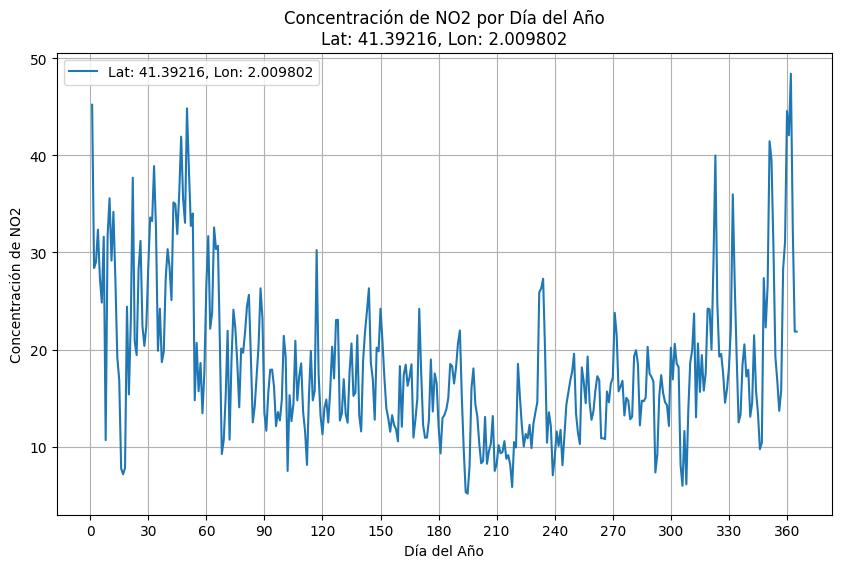

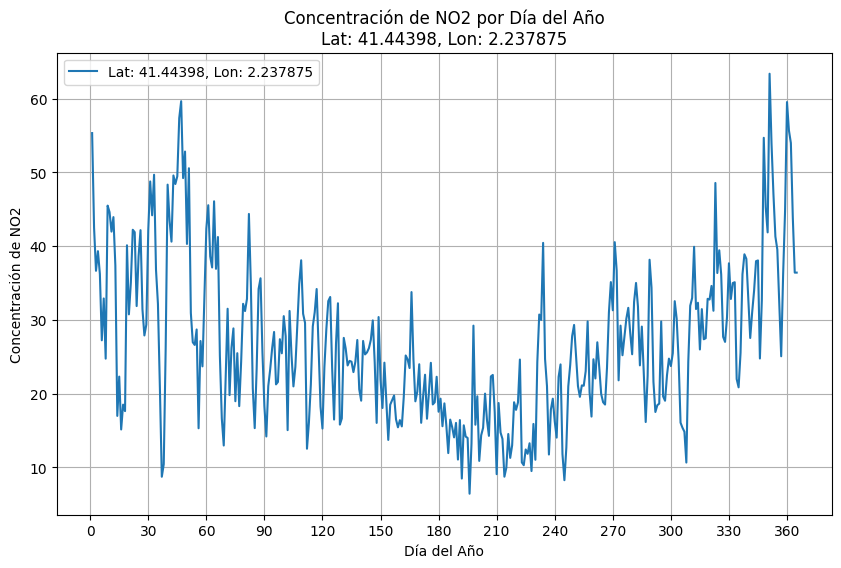

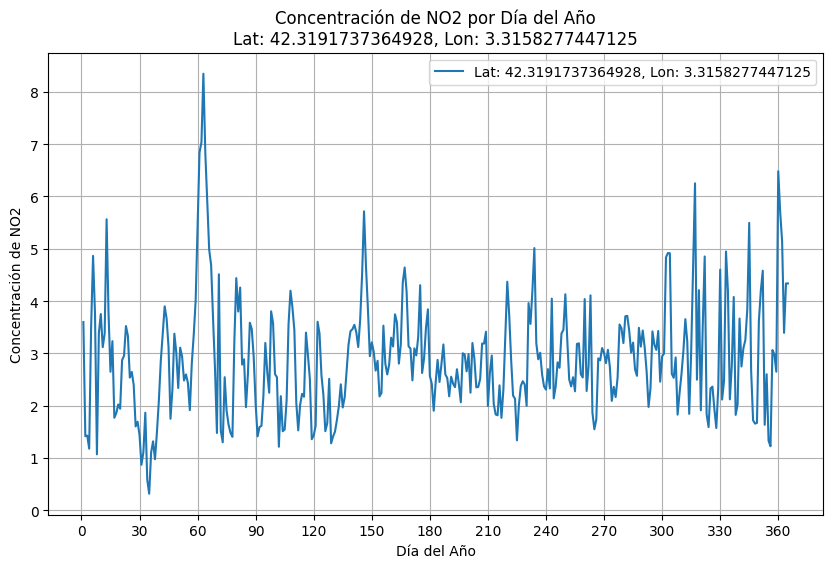

In [36]:
def plot_concentration_per_day(df):
    df['date'] = pd.to_datetime(df['date'])

    df['day_in_year'] = df['date'].dt.dayofyear

    grouped_df = df.groupby(['lat', 'lon', 'day_in_year'])['concentration'].mean().reset_index()

    for (lat, lon), group in grouped_df.groupby(['lat', 'lon']):
        plt.figure(figsize=(10, 6))
        plt.plot(group['day_in_year'], group['concentration'], label=f'Lat: {lat}, Lon: {lon}')
        plt.title(f'Concentración de NO2 por Día del Año\nLat: {lat}, Lon: {lon}')
        plt.xlabel('Día del Año')
        plt.ylabel('Concentración de NO2')
        plt.grid(True)
        plt.xticks(range(0, 367, 30))
        plt.legend()
        plt.show()

data = {
    'id': [1, 2],
    'date': ['2023-01-01 00:00', '2023-01-01 00:00'],
    'lat': [41.32177, 41.44398],
    'lon': [2.082141, 2.237875],
    'concentration': [30.9, 17.0]
}

plot_concentration_per_day(resultat_kaggle)